In [1]:
import collections
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import os
import torch

import preprocess
import postprocess

plt.style.use('https://raw.githubusercontent.com/RobGeada/stylelibs/main/material.mplstyle')

%load_ext autoreload
%autoreload 2

# Arguments

In [2]:
coco_path = "../test2017/" # if running in a docker image, this should be "/home/coco/"

images = list(os.listdir(coco_path))
image_path = coco_path+images[1]
model_url = "https://yolo-model-opendatahub-model.apps.trustyai.dzzt.p1.openshiftapps.com/v2/models/yolo-model" # put ODH model url here

# Preprocess
1) Load image from file
2) Pad it to square 
3) Convert into the kserve payload schema

In [ ]:
im = Image.open(image_path)
torch_im = torch.tensor(preprocess.get_as_numpy(im))
request_body = preprocess.to_kserve(im)
plt.imshow(im)
plt.show()

(640, 640, 3)
(640, 640, 3)


# Send To Model
(this can take a while)

In [40]:
response = requests.post(model_url+"/infer", json=request_body).json()

# Postprocess

In [41]:
# Process response to PyTorch tensors
pred_dict, proto_dict = response["outputs"]
pred = torch.tensor(pred_dict['data']).reshape(pred_dict['shape'])
proto = torch.tensor(proto_dict['data']).reshape(proto_dict['shape'])

# Set up mask generator
args = {"conf":.25, "iou":.45, "agnostic_nms": False, "max_det":1000}
segPredictor = postprocess.SegmentationPredictor(overrides=args)

# Put class names into mask generator
ModelSubstitute = collections.namedtuple("ModelSubstitute", ["names"])
segPredictor.model = ModelSubstitute(names=postprocess.names)
segPredictor.batch = [["."]]

# generate masks
results = segPredictor.postprocess([pred, proto], torch_im, torch_im)

# Visualize

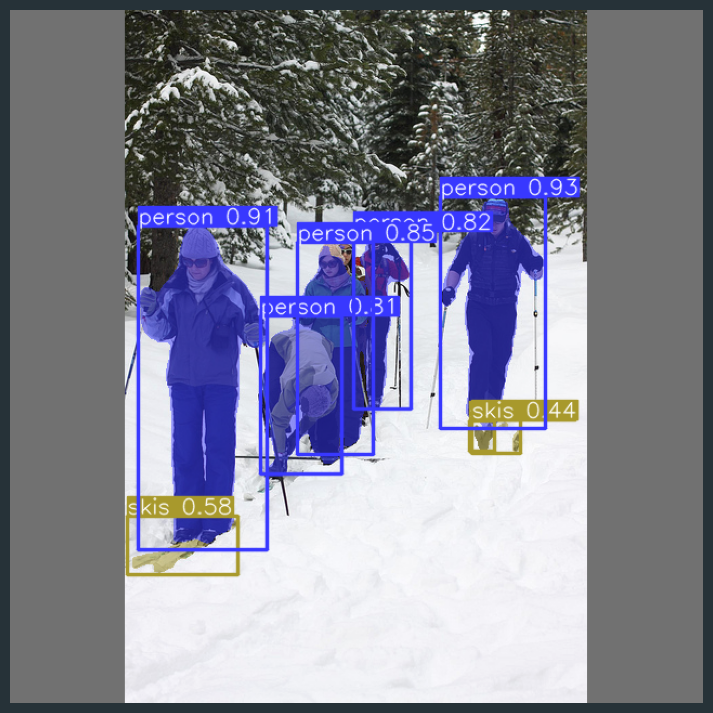

In [43]:
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()